Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


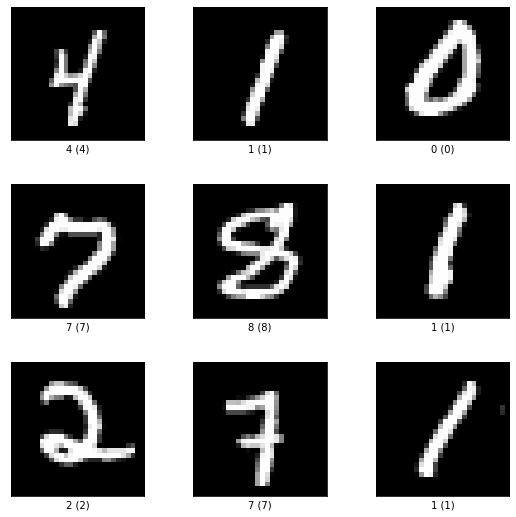

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


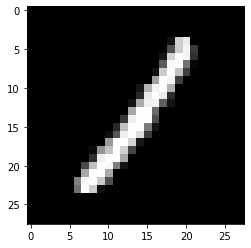

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.142841339111328, D:0.14290210604667664
[1/10 EPOCHS, 200 ITER] G:2.480988025665283, D:0.1271442025899887
[1/10 EPOCHS, 300 ITER] G:1.6415250301361084, D:0.25090980529785156
[1/10 EPOCHS, 400 ITER] G:2.4517006874084473, D:0.20581400394439697
[2/10 EPOCHS, 100 ITER] G:3.508455991744995, D:0.08996476233005524
[2/10 EPOCHS, 200 ITER] G:3.538264513015747, D:0.17347298562526703
[2/10 EPOCHS, 300 ITER] G:3.270289897918701, D:0.14066028594970703
[2/10 EPOCHS, 400 ITER] G:3.4292259216308594, D:0.11870291829109192
[3/10 EPOCHS, 100 ITER] G:3.6907873153686523, D:0.05254628509283066
[3/10 EPOCHS, 200 ITER] G:2.6984105110168457, D:0.1030806452035904
[3/10 EPOCHS, 300 ITER] G:3.267699718475342, D:0.059015385806560516
[3/10 EPOCHS, 400 ITER] G:3.5977234840393066, D:0.12235891819000244
[4/10 EPOCHS, 100 ITER] G:4.426037311553955, D:0.034432247281074524
[4/10 EPOCHS, 200 ITER] G:4.135621547698975, D:0.04268668591976166
[4/10 EPOCHS, 300 ITER] G:3.402742385864258, D:0.0733963

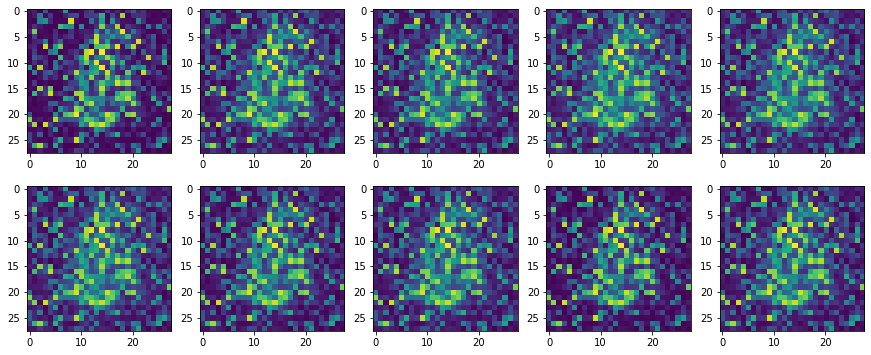

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

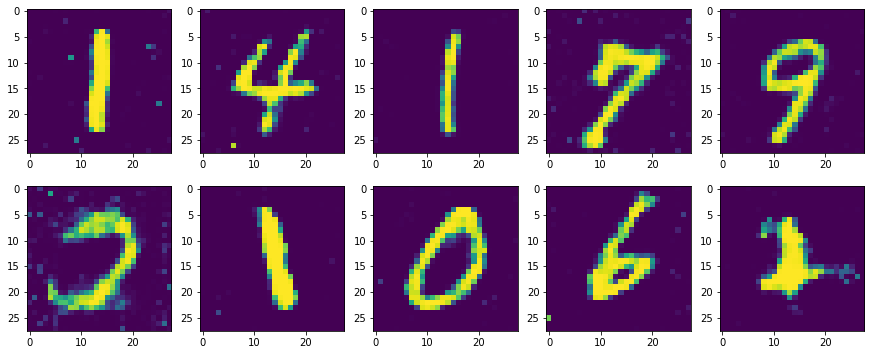

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.796160697937012, D:0.003830412169918418
[1/1 EPOCHS, 199 ITER] G:4.636246204376221, D:0.0655246153473854
[1/1 EPOCHS, 299 ITER] G:4.16658878326416, D:0.06658841669559479
[1/1 EPOCHS, 399 ITER] G:2.9324839115142822, D:0.255573034286499


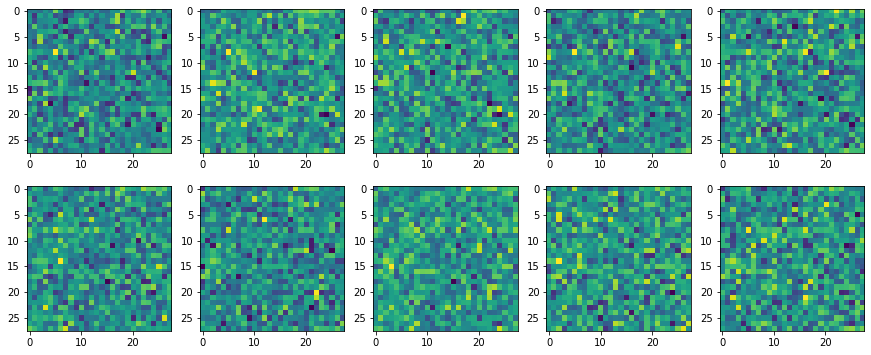

In [22]:
number = 7  

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [23]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


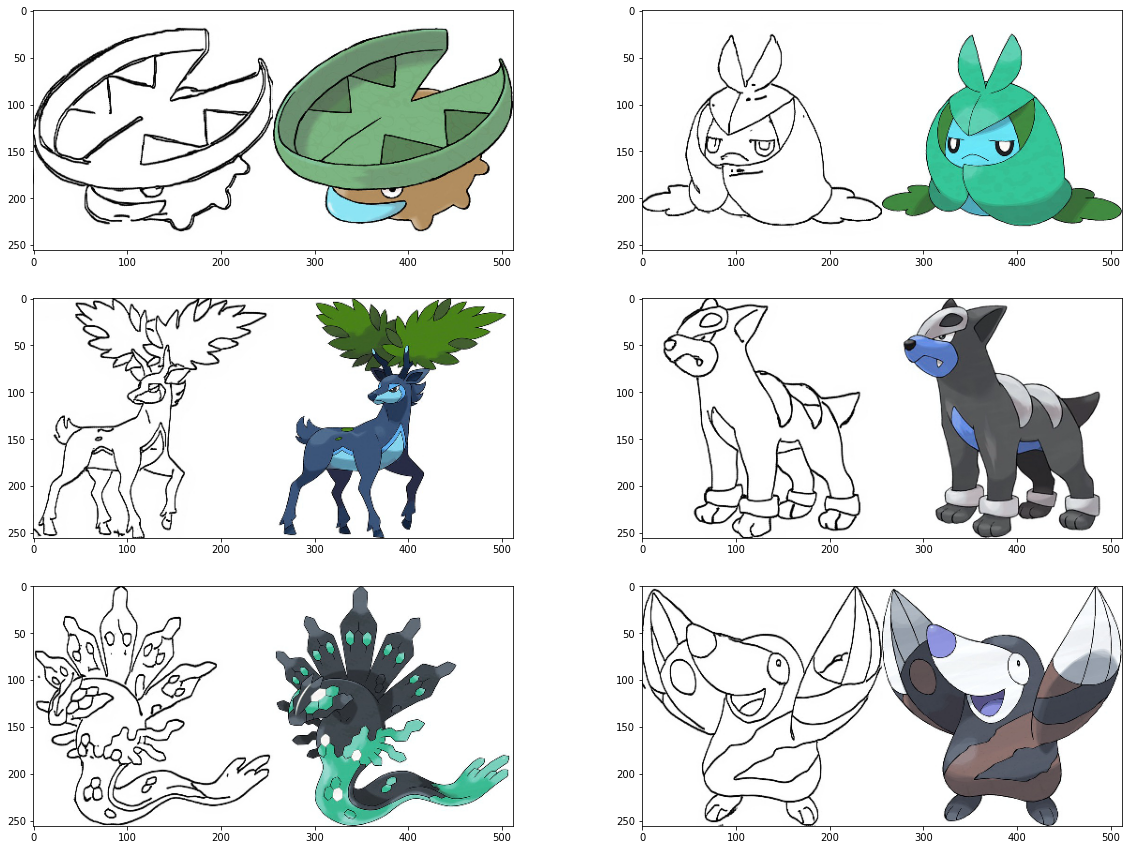

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [25]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


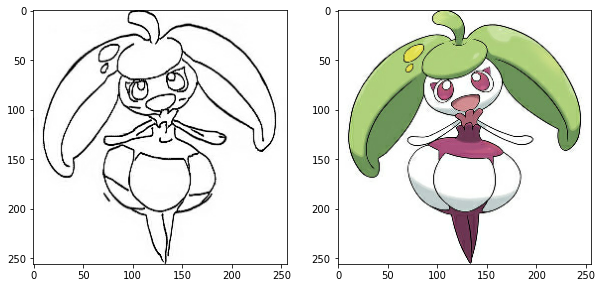

In [26]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [27]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


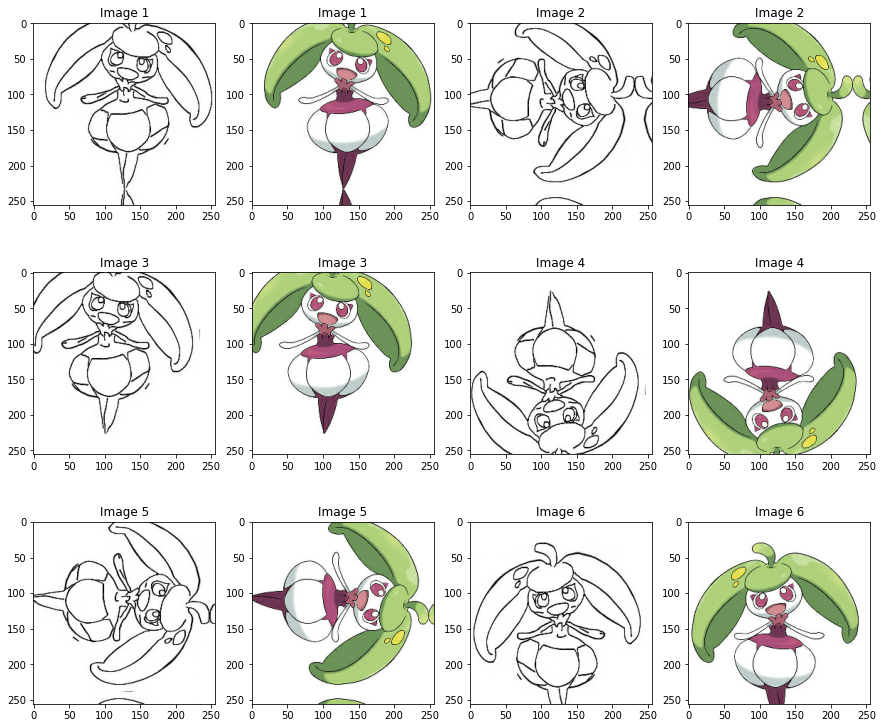

In [28]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

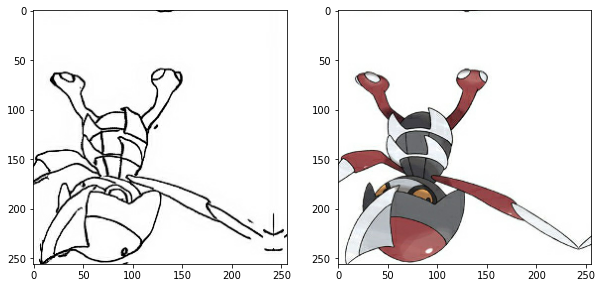

In [29]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [30]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [31]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [32]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [33]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [34]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [35]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [36]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [37]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [38]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

In [39]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [40]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [41]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [42]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

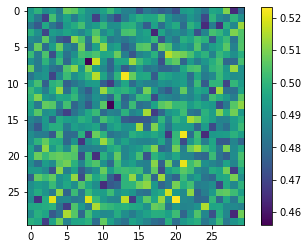

In [43]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [44]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [45]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [46]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [47]:
EPOCHS = 10 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9403                     
L1_loss:0.4847                     
Discriminator_loss:1.1700

EPOCH[1] - STEP[20]                     
Generator_loss:1.4554                     
L1_loss:0.2889                     
Discriminator_loss:1.6998

EPOCH[1] - STEP[30]                     
Generator_loss:1.0025                     
L1_loss:0.3109                     
Discriminator_loss:1.1381

EPOCH[1] - STEP[40]                     
Generator_loss:1.2716                     
L1_loss:0.3518                     
Discriminator_loss:0.9487

EPOCH[1] - STEP[50]                     
Generator_loss:1.4449                     
L1_loss:0.3215                     
Discriminator_loss:0.6558

EPOCH[1] - STEP[60]                     
Generator_loss:1.9579                     
L1_loss:0.2400                     
Discriminator_loss:0.4377

EPOCH[1] - STEP[70]                     
Generator_loss:1.8524                     
L1_loss:0.2650                    

EPOCH[3] - STEP[170]                     
Generator_loss:1.9732                     
L1_loss:0.2068                     
Discriminator_loss:0.6077

EPOCH[3] - STEP[180]                     
Generator_loss:2.9654                     
L1_loss:0.2645                     
Discriminator_loss:0.1472

EPOCH[3] - STEP[190]                     
Generator_loss:1.0566                     
L1_loss:0.2490                     
Discriminator_loss:0.7068

EPOCH[3] - STEP[200]                     
Generator_loss:2.1223                     
L1_loss:0.3136                     
Discriminator_loss:0.3341

EPOCH[4] - STEP[10]                     
Generator_loss:0.4355                     
L1_loss:0.2307                     
Discriminator_loss:1.5748

EPOCH[4] - STEP[20]                     
Generator_loss:1.7384                     
L1_loss:0.2895                     
Discriminator_loss:0.4352

EPOCH[4] - STEP[30]                     
Generator_loss:1.7827                     
L1_loss:0.2384                

EPOCH[6] - STEP[130]                     
Generator_loss:1.6354                     
L1_loss:0.2495                     
Discriminator_loss:0.2743

EPOCH[6] - STEP[140]                     
Generator_loss:0.1144                     
L1_loss:0.2371                     
Discriminator_loss:2.5051

EPOCH[6] - STEP[150]                     
Generator_loss:0.2957                     
L1_loss:0.2857                     
Discriminator_loss:1.5933

EPOCH[6] - STEP[160]                     
Generator_loss:3.0039                     
L1_loss:0.2469                     
Discriminator_loss:1.6471

EPOCH[6] - STEP[170]                     
Generator_loss:3.2142                     
L1_loss:0.3078                     
Discriminator_loss:0.1663

EPOCH[6] - STEP[180]                     
Generator_loss:3.6531                     
L1_loss:0.2365                     
Discriminator_loss:0.3911

EPOCH[6] - STEP[190]                     
Generator_loss:1.2990                     
L1_loss:0.2499             

EPOCH[9] - STEP[90]                     
Generator_loss:1.6457                     
L1_loss:0.2596                     
Discriminator_loss:0.3295

EPOCH[9] - STEP[100]                     
Generator_loss:2.6971                     
L1_loss:0.2810                     
Discriminator_loss:1.5186

EPOCH[9] - STEP[110]                     
Generator_loss:1.3846                     
L1_loss:0.2276                     
Discriminator_loss:1.0462

EPOCH[9] - STEP[120]                     
Generator_loss:2.4982                     
L1_loss:0.2348                     
Discriminator_loss:0.7314

EPOCH[9] - STEP[130]                     
Generator_loss:1.7362                     
L1_loss:0.2247                     
Discriminator_loss:1.4008

EPOCH[9] - STEP[140]                     
Generator_loss:1.0145                     
L1_loss:0.2683                     
Discriminator_loss:0.5690

EPOCH[9] - STEP[150]                     
Generator_loss:2.8389                     
L1_loss:0.2223              

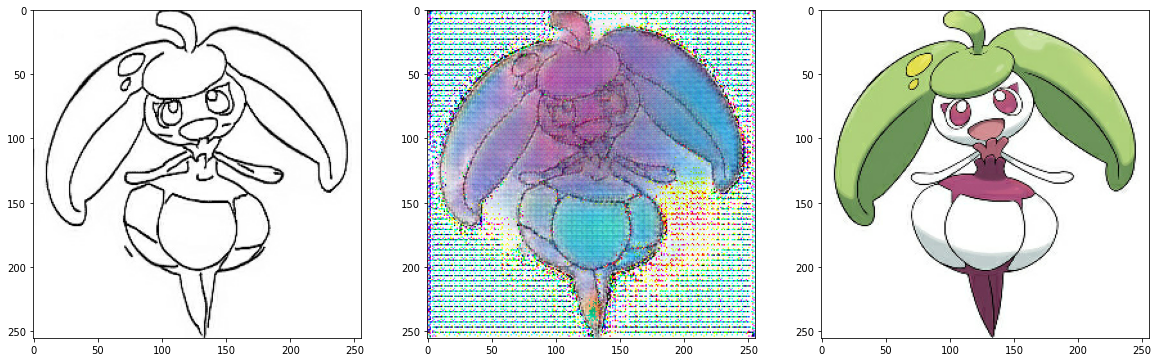

In [48]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [49]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


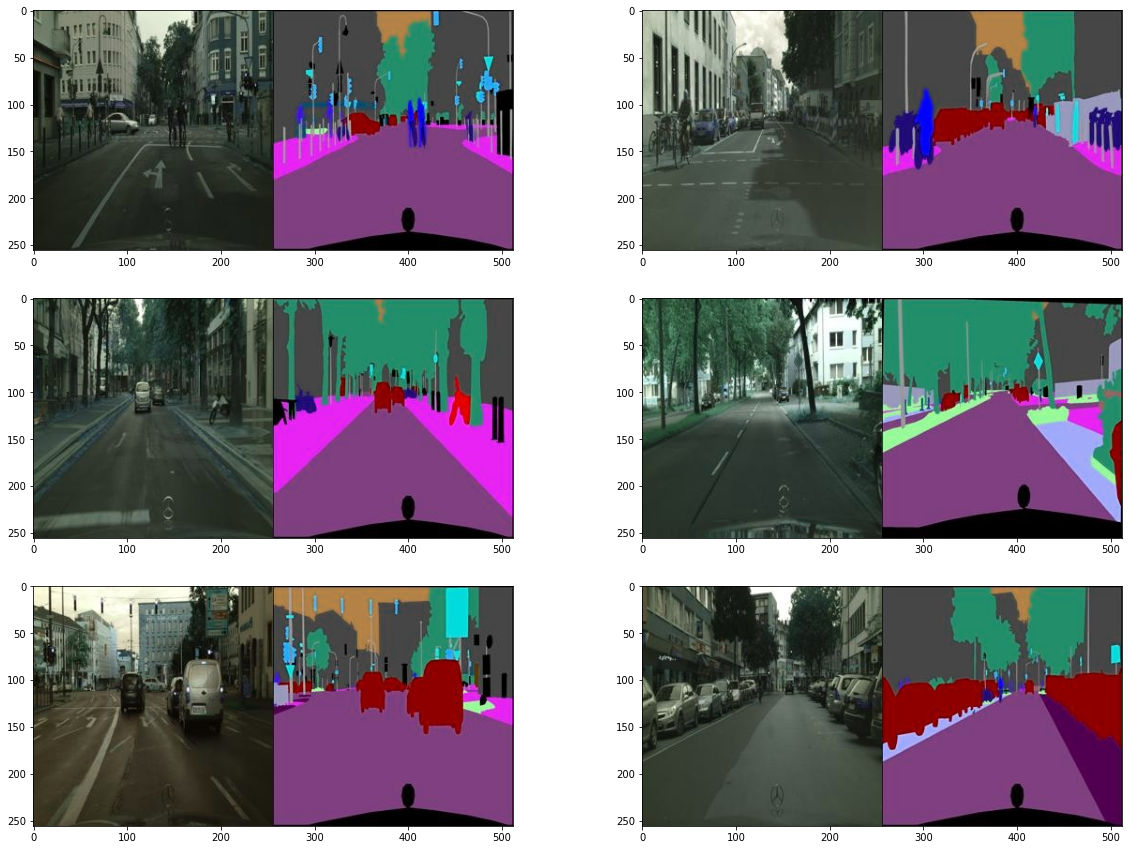

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [51]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


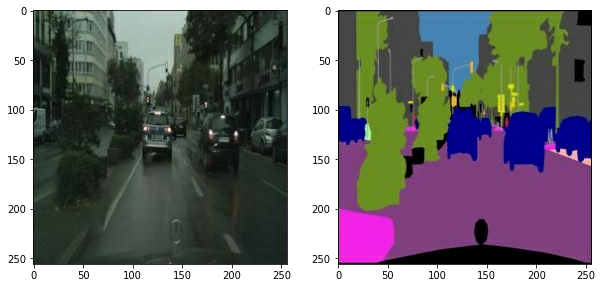

In [52]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [53]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    # 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    # 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop) 
    out = image.random_crop(padded, size=[256, 256, 6])
    # 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    out = image.random_flip_left_right(out)
    # 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down) 
    out = image.random_flip_up_down(out)
    # 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


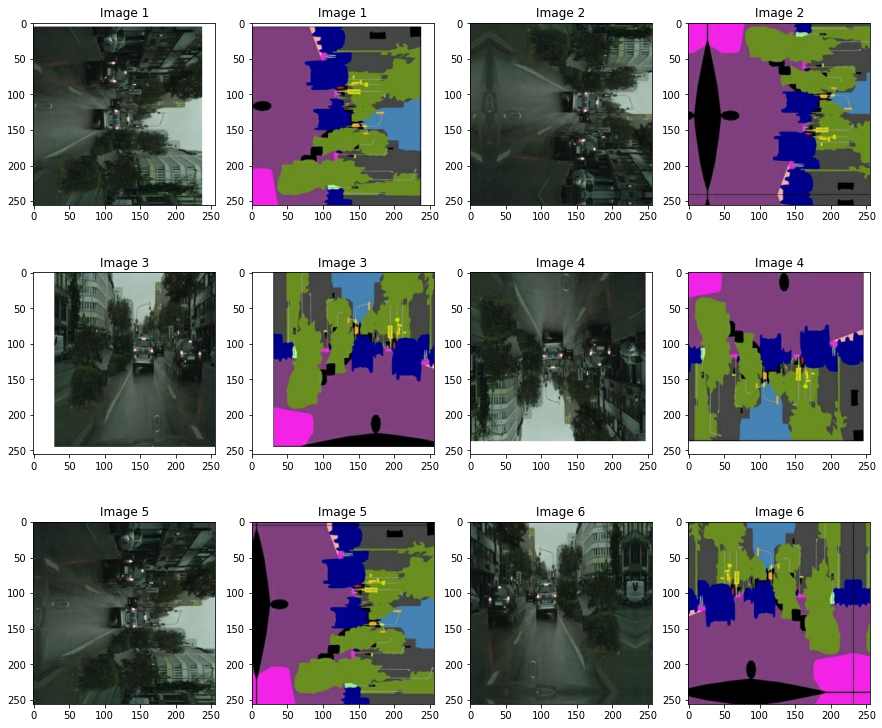

In [54]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

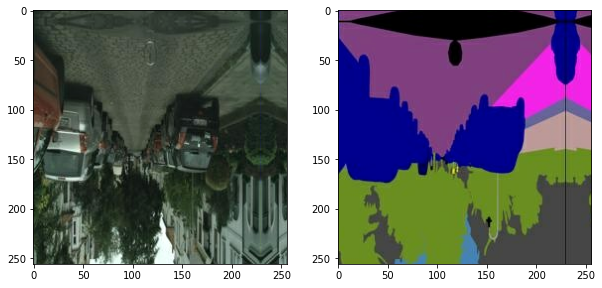

In [55]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [56]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [57]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [58]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [59]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [60]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [61]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9359                     
L1_loss:0.3135                     
Discriminator_loss:1.2939

EPOCH[1] - STEP[20]                     
Generator_loss:0.9960                     
L1_loss:0.2793                     
Discriminator_loss:1.3418

EPOCH[1] - STEP[30]                     
Generator_loss:1.1540                     
L1_loss:0.2486                     
Discriminator_loss:0.8720

EPOCH[1] - STEP[40]                     
Generator_loss:1.4790                     
L1_loss:0.2391                     
Discriminator_loss:0.8067

EPOCH[1] - STEP[50]                     
Generator_loss:1.6329                     
L1_loss:0.2497                     
Discriminator_loss:0.5759

EPOCH[1] - STEP[60]                     
Generator_loss:1.8528                     
L1_loss:0.2201                     
Discriminator_loss:0.4417

EPOCH[1] - STEP[70]                     
Generator_loss:1.9855                     
L1_loss:0.2396                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.3400                     
L1_loss:0.2222                     
Discriminator_loss:0.6109

EPOCH[3] - STEP[80]                     
Generator_loss:1.7421                     
L1_loss:0.2122                     
Discriminator_loss:0.3124

EPOCH[3] - STEP[90]                     
Generator_loss:2.8263                     
L1_loss:0.1882                     
Discriminator_loss:1.1674

EPOCH[3] - STEP[100]                     
Generator_loss:1.7875                     
L1_loss:0.1970                     
Discriminator_loss:0.5605

EPOCH[3] - STEP[110]                     
Generator_loss:1.0395                     
L1_loss:0.2037                     
Discriminator_loss:0.9609

EPOCH[3] - STEP[120]                     
Generator_loss:0.5062                     
L1_loss:0.1902                     
Discriminator_loss:1.0693

EPOCH[3] - STEP[130]                     
Generator_loss:1.1468                     
L1_loss:0.2077                

EPOCH[5] - STEP[130]                     
Generator_loss:1.5815                     
L1_loss:0.1732                     
Discriminator_loss:0.4914

EPOCH[5] - STEP[140]                     
Generator_loss:1.1084                     
L1_loss:0.1954                     
Discriminator_loss:1.9853

EPOCH[5] - STEP[150]                     
Generator_loss:1.6645                     
L1_loss:0.1570                     
Discriminator_loss:1.6957

EPOCH[5] - STEP[160]                     
Generator_loss:1.2810                     
L1_loss:0.1990                     
Discriminator_loss:1.1437

EPOCH[5] - STEP[170]                     
Generator_loss:2.4953                     
L1_loss:0.2218                     
Discriminator_loss:0.7855

EPOCH[5] - STEP[180]                     
Generator_loss:0.8313                     
L1_loss:0.1684                     
Discriminator_loss:1.1811

EPOCH[5] - STEP[190]                     
Generator_loss:1.7125                     
L1_loss:0.1777             

EPOCH[7] - STEP[190]                     
Generator_loss:1.8357                     
L1_loss:0.2047                     
Discriminator_loss:0.4503

EPOCH[7] - STEP[200]                     
Generator_loss:1.8881                     
L1_loss:0.2618                     
Discriminator_loss:0.6319

EPOCH[7] - STEP[210]                     
Generator_loss:2.0217                     
L1_loss:0.2262                     
Discriminator_loss:0.8471

EPOCH[7] - STEP[220]                     
Generator_loss:1.4451                     
L1_loss:0.1752                     
Discriminator_loss:0.5575

EPOCH[7] - STEP[230]                     
Generator_loss:1.6312                     
L1_loss:0.1848                     
Discriminator_loss:0.4681

EPOCH[7] - STEP[240]                     
Generator_loss:2.5151                     
L1_loss:0.2125                     
Discriminator_loss:0.4506

EPOCH[7] - STEP[250]                     
Generator_loss:2.0249                     
L1_loss:0.2023             

EPOCH[9] - STEP[250]                     
Generator_loss:2.4394                     
L1_loss:0.1920                     
Discriminator_loss:0.9033

EPOCH[10] - STEP[10]                     
Generator_loss:2.6393                     
L1_loss:0.1838                     
Discriminator_loss:0.8039

EPOCH[10] - STEP[20]                     
Generator_loss:2.5406                     
L1_loss:0.1941                     
Discriminator_loss:1.0646

EPOCH[10] - STEP[30]                     
Generator_loss:3.2016                     
L1_loss:0.1591                     
Discriminator_loss:0.6833

EPOCH[10] - STEP[40]                     
Generator_loss:1.6875                     
L1_loss:0.1896                     
Discriminator_loss:0.4807

EPOCH[10] - STEP[50]                     
Generator_loss:0.3246                     
L1_loss:0.1777                     
Discriminator_loss:1.5935

EPOCH[10] - STEP[60]                     
Generator_loss:1.5561                     
L1_loss:0.1684             

EPOCH[12] - STEP[60]                     
Generator_loss:0.9573                     
L1_loss:0.1645                     
Discriminator_loss:1.1414

EPOCH[12] - STEP[70]                     
Generator_loss:1.4806                     
L1_loss:0.1839                     
Discriminator_loss:0.9699

EPOCH[12] - STEP[80]                     
Generator_loss:2.1718                     
L1_loss:0.1661                     
Discriminator_loss:0.4644

EPOCH[12] - STEP[90]                     
Generator_loss:1.2454                     
L1_loss:0.1405                     
Discriminator_loss:0.4981

EPOCH[12] - STEP[100]                     
Generator_loss:1.0805                     
L1_loss:0.1957                     
Discriminator_loss:0.6257

EPOCH[12] - STEP[110]                     
Generator_loss:0.9680                     
L1_loss:0.1624                     
Discriminator_loss:0.6039

EPOCH[12] - STEP[120]                     
Generator_loss:2.4886                     
L1_loss:0.1854          

EPOCH[14] - STEP[120]                     
Generator_loss:0.9664                     
L1_loss:0.1526                     
Discriminator_loss:0.8822

EPOCH[14] - STEP[130]                     
Generator_loss:2.1508                     
L1_loss:0.1754                     
Discriminator_loss:1.0109

EPOCH[14] - STEP[140]                     
Generator_loss:0.8562                     
L1_loss:0.1888                     
Discriminator_loss:0.6779

EPOCH[14] - STEP[150]                     
Generator_loss:2.5794                     
L1_loss:0.1897                     
Discriminator_loss:0.2455

EPOCH[14] - STEP[160]                     
Generator_loss:1.7447                     
L1_loss:0.1720                     
Discriminator_loss:0.6795

EPOCH[14] - STEP[170]                     
Generator_loss:1.0089                     
L1_loss:0.1652                     
Discriminator_loss:0.7259

EPOCH[14] - STEP[180]                     
Generator_loss:1.6342                     
L1_loss:0.1925      

EPOCH[16] - STEP[180]                     
Generator_loss:1.6044                     
L1_loss:0.1996                     
Discriminator_loss:0.5687

EPOCH[16] - STEP[190]                     
Generator_loss:2.7275                     
L1_loss:0.1899                     
Discriminator_loss:0.3886

EPOCH[16] - STEP[200]                     
Generator_loss:1.3289                     
L1_loss:0.1589                     
Discriminator_loss:0.5901

EPOCH[16] - STEP[210]                     
Generator_loss:1.4721                     
L1_loss:0.1484                     
Discriminator_loss:0.6477

EPOCH[16] - STEP[220]                     
Generator_loss:1.5282                     
L1_loss:0.1808                     
Discriminator_loss:0.3995

EPOCH[16] - STEP[230]                     
Generator_loss:2.9199                     
L1_loss:0.2109                     
Discriminator_loss:0.5595

EPOCH[16] - STEP[240]                     
Generator_loss:2.5452                     
L1_loss:0.1700      

EPOCH[18] - STEP[240]                     
Generator_loss:2.8957                     
L1_loss:0.1591                     
Discriminator_loss:0.2160

EPOCH[18] - STEP[250]                     
Generator_loss:1.5404                     
L1_loss:0.1878                     
Discriminator_loss:0.4657

EPOCH[19] - STEP[10]                     
Generator_loss:3.1972                     
L1_loss:0.1827                     
Discriminator_loss:0.0856

EPOCH[19] - STEP[20]                     
Generator_loss:2.5989                     
L1_loss:0.2213                     
Discriminator_loss:0.3623

EPOCH[19] - STEP[30]                     
Generator_loss:2.0741                     
L1_loss:0.1473                     
Discriminator_loss:0.5106

EPOCH[19] - STEP[40]                     
Generator_loss:1.4923                     
L1_loss:0.1761                     
Discriminator_loss:0.6166

EPOCH[19] - STEP[50]                     
Generator_loss:1.0824                     
L1_loss:0.2016           

EPOCH[21] - STEP[50]                     
Generator_loss:1.3703                     
L1_loss:0.1517                     
Discriminator_loss:0.4839

EPOCH[21] - STEP[60]                     
Generator_loss:2.9195                     
L1_loss:0.1390                     
Discriminator_loss:0.6922

EPOCH[21] - STEP[70]                     
Generator_loss:1.8959                     
L1_loss:0.2343                     
Discriminator_loss:0.4343

EPOCH[21] - STEP[80]                     
Generator_loss:2.3999                     
L1_loss:0.1594                     
Discriminator_loss:0.2595

EPOCH[21] - STEP[90]                     
Generator_loss:2.1090                     
L1_loss:0.1298                     
Discriminator_loss:0.9119

EPOCH[21] - STEP[100]                     
Generator_loss:3.6240                     
L1_loss:0.1779                     
Discriminator_loss:0.5557

EPOCH[21] - STEP[110]                     
Generator_loss:1.4321                     
L1_loss:0.1958           

EPOCH[23] - STEP[110]                     
Generator_loss:1.9167                     
L1_loss:0.1991                     
Discriminator_loss:0.3754

EPOCH[23] - STEP[120]                     
Generator_loss:0.9795                     
L1_loss:0.1279                     
Discriminator_loss:0.8785

EPOCH[23] - STEP[130]                     
Generator_loss:2.3601                     
L1_loss:0.1616                     
Discriminator_loss:0.3147

EPOCH[23] - STEP[140]                     
Generator_loss:0.8943                     
L1_loss:0.1488                     
Discriminator_loss:1.1424

EPOCH[23] - STEP[150]                     
Generator_loss:2.4433                     
L1_loss:0.1360                     
Discriminator_loss:0.5458

EPOCH[23] - STEP[160]                     
Generator_loss:1.6507                     
L1_loss:0.1450                     
Discriminator_loss:1.0399

EPOCH[23] - STEP[170]                     
Generator_loss:1.8431                     
L1_loss:0.1488      

EPOCH[25] - STEP[170]                     
Generator_loss:1.9233                     
L1_loss:0.1445                     
Discriminator_loss:0.3581

EPOCH[25] - STEP[180]                     
Generator_loss:0.7318                     
L1_loss:0.1438                     
Discriminator_loss:0.9541

EPOCH[25] - STEP[190]                     
Generator_loss:1.0062                     
L1_loss:0.1132                     
Discriminator_loss:0.9197

EPOCH[25] - STEP[200]                     
Generator_loss:2.0754                     
L1_loss:0.1957                     
Discriminator_loss:0.4209

EPOCH[25] - STEP[210]                     
Generator_loss:2.5824                     
L1_loss:0.1414                     
Discriminator_loss:0.8233

EPOCH[25] - STEP[220]                     
Generator_loss:2.4912                     
L1_loss:0.1908                     
Discriminator_loss:0.1467

EPOCH[25] - STEP[230]                     
Generator_loss:2.4490                     
L1_loss:0.1455      

EPOCH[27] - STEP[230]                     
Generator_loss:2.4450                     
L1_loss:0.1778                     
Discriminator_loss:0.1909

EPOCH[27] - STEP[240]                     
Generator_loss:2.5494                     
L1_loss:0.1525                     
Discriminator_loss:0.1630

EPOCH[27] - STEP[250]                     
Generator_loss:0.3170                     
L1_loss:0.1633                     
Discriminator_loss:1.8113

EPOCH[28] - STEP[10]                     
Generator_loss:2.7864                     
L1_loss:0.1633                     
Discriminator_loss:0.4197

EPOCH[28] - STEP[20]                     
Generator_loss:2.8507                     
L1_loss:0.1907                     
Discriminator_loss:0.5259

EPOCH[28] - STEP[30]                     
Generator_loss:1.3930                     
L1_loss:0.1495                     
Discriminator_loss:0.6663

EPOCH[28] - STEP[40]                     
Generator_loss:2.0203                     
L1_loss:0.1380          

EPOCH[30] - STEP[40]                     
Generator_loss:2.8093                     
L1_loss:0.1350                     
Discriminator_loss:1.3445

EPOCH[30] - STEP[50]                     
Generator_loss:2.2514                     
L1_loss:0.1717                     
Discriminator_loss:0.2546

EPOCH[30] - STEP[60]                     
Generator_loss:2.9193                     
L1_loss:0.1315                     
Discriminator_loss:1.0735

EPOCH[30] - STEP[70]                     
Generator_loss:2.5892                     
L1_loss:0.1691                     
Discriminator_loss:0.6391

EPOCH[30] - STEP[80]                     
Generator_loss:0.5354                     
L1_loss:0.1434                     
Discriminator_loss:1.5798

EPOCH[30] - STEP[90]                     
Generator_loss:2.3157                     
L1_loss:0.1598                     
Discriminator_loss:0.3033

EPOCH[30] - STEP[100]                     
Generator_loss:3.2841                     
L1_loss:0.1624            

EPOCH[32] - STEP[100]                     
Generator_loss:2.4909                     
L1_loss:0.1552                     
Discriminator_loss:0.3181

EPOCH[32] - STEP[110]                     
Generator_loss:3.0003                     
L1_loss:0.1934                     
Discriminator_loss:0.1381

EPOCH[32] - STEP[120]                     
Generator_loss:3.0006                     
L1_loss:0.1885                     
Discriminator_loss:0.2374

EPOCH[32] - STEP[130]                     
Generator_loss:2.0404                     
L1_loss:0.1558                     
Discriminator_loss:0.2883

EPOCH[32] - STEP[140]                     
Generator_loss:1.4039                     
L1_loss:0.1335                     
Discriminator_loss:0.7468

EPOCH[32] - STEP[150]                     
Generator_loss:2.1817                     
L1_loss:0.1581                     
Discriminator_loss:0.2680

EPOCH[32] - STEP[160]                     
Generator_loss:3.2016                     
L1_loss:0.1540      

EPOCH[34] - STEP[160]                     
Generator_loss:1.9001                     
L1_loss:0.1617                     
Discriminator_loss:0.9728

EPOCH[34] - STEP[170]                     
Generator_loss:3.5676                     
L1_loss:0.2070                     
Discriminator_loss:0.1282

EPOCH[34] - STEP[180]                     
Generator_loss:1.2328                     
L1_loss:0.1717                     
Discriminator_loss:0.5058

EPOCH[34] - STEP[190]                     
Generator_loss:2.6714                     
L1_loss:0.1293                     
Discriminator_loss:1.1775

EPOCH[34] - STEP[200]                     
Generator_loss:2.2412                     
L1_loss:0.1888                     
Discriminator_loss:0.3564

EPOCH[34] - STEP[210]                     
Generator_loss:0.6864                     
L1_loss:0.1554                     
Discriminator_loss:1.0881

EPOCH[34] - STEP[220]                     
Generator_loss:2.8439                     
L1_loss:0.1367      

EPOCH[36] - STEP[220]                     
Generator_loss:4.4732                     
L1_loss:0.1450                     
Discriminator_loss:1.2576

EPOCH[36] - STEP[230]                     
Generator_loss:5.4288                     
L1_loss:0.1986                     
Discriminator_loss:0.7776

EPOCH[36] - STEP[240]                     
Generator_loss:2.6266                     
L1_loss:0.1318                     
Discriminator_loss:0.1906

EPOCH[36] - STEP[250]                     
Generator_loss:2.2127                     
L1_loss:0.1977                     
Discriminator_loss:0.2483

EPOCH[37] - STEP[10]                     
Generator_loss:1.1274                     
L1_loss:0.1383                     
Discriminator_loss:0.5359

EPOCH[37] - STEP[20]                     
Generator_loss:2.4913                     
L1_loss:0.1295                     
Discriminator_loss:0.2295

EPOCH[37] - STEP[30]                     
Generator_loss:2.2617                     
L1_loss:0.1316         

EPOCH[39] - STEP[30]                     
Generator_loss:3.0402                     
L1_loss:0.1711                     
Discriminator_loss:0.1235

EPOCH[39] - STEP[40]                     
Generator_loss:4.3197                     
L1_loss:0.1690                     
Discriminator_loss:0.0575

EPOCH[39] - STEP[50]                     
Generator_loss:5.4464                     
L1_loss:0.1455                     
Discriminator_loss:0.1653

EPOCH[39] - STEP[60]                     
Generator_loss:2.3863                     
L1_loss:0.1342                     
Discriminator_loss:0.4023

EPOCH[39] - STEP[70]                     
Generator_loss:5.5618                     
L1_loss:0.1345                     
Discriminator_loss:1.5687

EPOCH[39] - STEP[80]                     
Generator_loss:2.7189                     
L1_loss:0.1409                     
Discriminator_loss:0.5327

EPOCH[39] - STEP[90]                     
Generator_loss:4.0708                     
L1_loss:0.1301             

EPOCH[41] - STEP[90]                     
Generator_loss:3.2748                     
L1_loss:0.1336                     
Discriminator_loss:0.2686

EPOCH[41] - STEP[100]                     
Generator_loss:2.0042                     
L1_loss:0.1331                     
Discriminator_loss:0.5211

EPOCH[41] - STEP[110]                     
Generator_loss:3.5063                     
L1_loss:0.1648                     
Discriminator_loss:0.1565

EPOCH[41] - STEP[120]                     
Generator_loss:4.1916                     
L1_loss:0.1432                     
Discriminator_loss:0.7161

EPOCH[41] - STEP[130]                     
Generator_loss:3.6602                     
L1_loss:0.1355                     
Discriminator_loss:0.4917

EPOCH[41] - STEP[140]                     
Generator_loss:5.0460                     
L1_loss:0.1476                     
Discriminator_loss:0.2449

EPOCH[41] - STEP[150]                     
Generator_loss:1.4584                     
L1_loss:0.2024       

EPOCH[43] - STEP[150]                     
Generator_loss:2.9774                     
L1_loss:0.1569                     
Discriminator_loss:0.1893

EPOCH[43] - STEP[160]                     
Generator_loss:4.6649                     
L1_loss:0.1460                     
Discriminator_loss:1.1659

EPOCH[43] - STEP[170]                     
Generator_loss:4.9981                     
L1_loss:0.1143                     
Discriminator_loss:0.5649

EPOCH[43] - STEP[180]                     
Generator_loss:2.2706                     
L1_loss:0.1835                     
Discriminator_loss:0.3673

EPOCH[43] - STEP[190]                     
Generator_loss:2.7488                     
L1_loss:0.1321                     
Discriminator_loss:0.2498

EPOCH[43] - STEP[200]                     
Generator_loss:3.7090                     
L1_loss:0.1435                     
Discriminator_loss:0.1099

EPOCH[43] - STEP[210]                     
Generator_loss:1.5714                     
L1_loss:0.1123      

EPOCH[45] - STEP[210]                     
Generator_loss:0.8149                     
L1_loss:0.1284                     
Discriminator_loss:0.8729

EPOCH[45] - STEP[220]                     
Generator_loss:3.9657                     
L1_loss:0.1393                     
Discriminator_loss:0.3456

EPOCH[45] - STEP[230]                     
Generator_loss:2.6259                     
L1_loss:0.1364                     
Discriminator_loss:0.4786

EPOCH[45] - STEP[240]                     
Generator_loss:4.2625                     
L1_loss:0.1330                     
Discriminator_loss:0.5028

EPOCH[45] - STEP[250]                     
Generator_loss:1.9926                     
L1_loss:0.1146                     
Discriminator_loss:0.6120

EPOCH[46] - STEP[10]                     
Generator_loss:3.8245                     
L1_loss:0.1250                     
Discriminator_loss:0.2517

EPOCH[46] - STEP[20]                     
Generator_loss:2.1919                     
L1_loss:0.1334        

EPOCH[48] - STEP[20]                     
Generator_loss:3.0889                     
L1_loss:0.1752                     
Discriminator_loss:0.0978

EPOCH[48] - STEP[30]                     
Generator_loss:1.7536                     
L1_loss:0.1474                     
Discriminator_loss:0.3624

EPOCH[48] - STEP[40]                     
Generator_loss:2.5719                     
L1_loss:0.1329                     
Discriminator_loss:0.2857

EPOCH[48] - STEP[50]                     
Generator_loss:2.3424                     
L1_loss:0.1488                     
Discriminator_loss:0.2476

EPOCH[48] - STEP[60]                     
Generator_loss:1.9521                     
L1_loss:0.1597                     
Discriminator_loss:0.4596

EPOCH[48] - STEP[70]                     
Generator_loss:2.0895                     
L1_loss:0.1389                     
Discriminator_loss:0.8346

EPOCH[48] - STEP[80]                     
Generator_loss:3.1805                     
L1_loss:0.1624             

EPOCH[50] - STEP[80]                     
Generator_loss:1.5874                     
L1_loss:0.1171                     
Discriminator_loss:0.4181

EPOCH[50] - STEP[90]                     
Generator_loss:3.5692                     
L1_loss:0.1482                     
Discriminator_loss:0.3145

EPOCH[50] - STEP[100]                     
Generator_loss:0.7876                     
L1_loss:0.1396                     
Discriminator_loss:0.8986

EPOCH[50] - STEP[110]                     
Generator_loss:4.2066                     
L1_loss:0.1779                     
Discriminator_loss:0.1470

EPOCH[50] - STEP[120]                     
Generator_loss:3.0346                     
L1_loss:0.1301                     
Discriminator_loss:0.3851

EPOCH[50] - STEP[130]                     
Generator_loss:4.5375                     
L1_loss:0.1613                     
Discriminator_loss:0.1160

EPOCH[50] - STEP[140]                     
Generator_loss:3.1341                     
L1_loss:0.1732        

EPOCH[52] - STEP[140]                     
Generator_loss:0.9688                     
L1_loss:0.1427                     
Discriminator_loss:1.0207

EPOCH[52] - STEP[150]                     
Generator_loss:0.3700                     
L1_loss:0.1603                     
Discriminator_loss:1.9031

EPOCH[52] - STEP[160]                     
Generator_loss:4.3728                     
L1_loss:0.1486                     
Discriminator_loss:0.2616

EPOCH[52] - STEP[170]                     
Generator_loss:2.1367                     
L1_loss:0.1224                     
Discriminator_loss:0.3530

EPOCH[52] - STEP[180]                     
Generator_loss:3.8616                     
L1_loss:0.1303                     
Discriminator_loss:0.1686

EPOCH[52] - STEP[190]                     
Generator_loss:2.6673                     
L1_loss:0.1242                     
Discriminator_loss:0.5433

EPOCH[52] - STEP[200]                     
Generator_loss:4.0628                     
L1_loss:0.1190      

EPOCH[54] - STEP[200]                     
Generator_loss:4.8454                     
L1_loss:0.1192                     
Discriminator_loss:0.0593

EPOCH[54] - STEP[210]                     
Generator_loss:3.4919                     
L1_loss:0.1406                     
Discriminator_loss:0.0708

EPOCH[54] - STEP[220]                     
Generator_loss:4.8826                     
L1_loss:0.1312                     
Discriminator_loss:0.6699

EPOCH[54] - STEP[230]                     
Generator_loss:0.4692                     
L1_loss:0.1609                     
Discriminator_loss:1.2625

EPOCH[54] - STEP[240]                     
Generator_loss:1.9097                     
L1_loss:0.1543                     
Discriminator_loss:0.3906

EPOCH[54] - STEP[250]                     
Generator_loss:1.6807                     
L1_loss:0.1347                     
Discriminator_loss:0.5222

EPOCH[55] - STEP[10]                     
Generator_loss:4.2948                     
L1_loss:0.1409       

EPOCH[57] - STEP[10]                     
Generator_loss:2.6391                     
L1_loss:0.1182                     
Discriminator_loss:0.4566

EPOCH[57] - STEP[20]                     
Generator_loss:3.0619                     
L1_loss:0.1525                     
Discriminator_loss:0.2700

EPOCH[57] - STEP[30]                     
Generator_loss:4.4361                     
L1_loss:0.1637                     
Discriminator_loss:0.0490

EPOCH[57] - STEP[40]                     
Generator_loss:2.0863                     
L1_loss:0.1172                     
Discriminator_loss:0.5186

EPOCH[57] - STEP[50]                     
Generator_loss:2.4108                     
L1_loss:0.1607                     
Discriminator_loss:0.1575

EPOCH[57] - STEP[60]                     
Generator_loss:2.5224                     
L1_loss:0.1553                     
Discriminator_loss:0.2246

EPOCH[57] - STEP[70]                     
Generator_loss:3.6933                     
L1_loss:0.1506             

EPOCH[59] - STEP[70]                     
Generator_loss:1.2732                     
L1_loss:0.1141                     
Discriminator_loss:0.8012

EPOCH[59] - STEP[80]                     
Generator_loss:3.8546                     
L1_loss:0.1352                     
Discriminator_loss:0.8049

EPOCH[59] - STEP[90]                     
Generator_loss:1.1965                     
L1_loss:0.1636                     
Discriminator_loss:0.6635

EPOCH[59] - STEP[100]                     
Generator_loss:3.8955                     
L1_loss:0.1564                     
Discriminator_loss:0.6378

EPOCH[59] - STEP[110]                     
Generator_loss:4.2858                     
L1_loss:0.1598                     
Discriminator_loss:0.8042

EPOCH[59] - STEP[120]                     
Generator_loss:1.0736                     
L1_loss:0.1365                     
Discriminator_loss:1.0200

EPOCH[59] - STEP[130]                     
Generator_loss:0.5924                     
L1_loss:0.1243         

EPOCH[61] - STEP[130]                     
Generator_loss:0.7647                     
L1_loss:0.1447                     
Discriminator_loss:1.0578

EPOCH[61] - STEP[140]                     
Generator_loss:3.7687                     
L1_loss:0.1686                     
Discriminator_loss:0.0812

EPOCH[61] - STEP[150]                     
Generator_loss:2.1575                     
L1_loss:0.1354                     
Discriminator_loss:0.2209

EPOCH[61] - STEP[160]                     
Generator_loss:3.8624                     
L1_loss:0.1492                     
Discriminator_loss:0.2332

EPOCH[61] - STEP[170]                     
Generator_loss:3.2962                     
L1_loss:0.1330                     
Discriminator_loss:0.4124

EPOCH[61] - STEP[180]                     
Generator_loss:1.8765                     
L1_loss:0.1657                     
Discriminator_loss:0.2790

EPOCH[61] - STEP[190]                     
Generator_loss:3.0109                     
L1_loss:0.1446      

EPOCH[63] - STEP[190]                     
Generator_loss:1.3105                     
L1_loss:0.1276                     
Discriminator_loss:0.5526

EPOCH[63] - STEP[200]                     
Generator_loss:4.0120                     
L1_loss:0.1776                     
Discriminator_loss:0.1648

EPOCH[63] - STEP[210]                     
Generator_loss:2.9375                     
L1_loss:0.1554                     
Discriminator_loss:0.2368

EPOCH[63] - STEP[220]                     
Generator_loss:1.8727                     
L1_loss:0.1273                     
Discriminator_loss:0.5814

EPOCH[63] - STEP[230]                     
Generator_loss:4.3687                     
L1_loss:0.1561                     
Discriminator_loss:0.2734

EPOCH[63] - STEP[240]                     
Generator_loss:3.6934                     
L1_loss:0.1433                     
Discriminator_loss:0.1341

EPOCH[63] - STEP[250]                     
Generator_loss:3.8449                     
L1_loss:0.1281      

EPOCH[65] - STEP[250]                     
Generator_loss:1.3214                     
L1_loss:0.1343                     
Discriminator_loss:0.5424

EPOCH[66] - STEP[10]                     
Generator_loss:1.7567                     
L1_loss:0.1494                     
Discriminator_loss:0.3704

EPOCH[66] - STEP[20]                     
Generator_loss:4.6314                     
L1_loss:0.1528                     
Discriminator_loss:0.0610

EPOCH[66] - STEP[30]                     
Generator_loss:3.4194                     
L1_loss:0.1261                     
Discriminator_loss:0.6627

EPOCH[66] - STEP[40]                     
Generator_loss:2.4934                     
L1_loss:0.1647                     
Discriminator_loss:0.2497

EPOCH[66] - STEP[50]                     
Generator_loss:3.2991                     
L1_loss:0.1244                     
Discriminator_loss:0.1879

EPOCH[66] - STEP[60]                     
Generator_loss:3.3868                     
L1_loss:0.1333            

EPOCH[68] - STEP[60]                     
Generator_loss:3.8631                     
L1_loss:0.1381                     
Discriminator_loss:0.1593

EPOCH[68] - STEP[70]                     
Generator_loss:3.7584                     
L1_loss:0.1737                     
Discriminator_loss:0.0477

EPOCH[68] - STEP[80]                     
Generator_loss:1.3045                     
L1_loss:0.1311                     
Discriminator_loss:0.7045

EPOCH[68] - STEP[90]                     
Generator_loss:2.5351                     
L1_loss:0.1238                     
Discriminator_loss:0.1458

EPOCH[68] - STEP[100]                     
Generator_loss:3.6330                     
L1_loss:0.1464                     
Discriminator_loss:0.1193

EPOCH[68] - STEP[110]                     
Generator_loss:1.3855                     
L1_loss:0.1252                     
Discriminator_loss:0.5180

EPOCH[68] - STEP[120]                     
Generator_loss:4.3533                     
L1_loss:0.1350          

EPOCH[70] - STEP[120]                     
Generator_loss:3.2637                     
L1_loss:0.1590                     
Discriminator_loss:0.0762

EPOCH[70] - STEP[130]                     
Generator_loss:4.8865                     
L1_loss:0.1160                     
Discriminator_loss:0.3505

EPOCH[70] - STEP[140]                     
Generator_loss:5.0702                     
L1_loss:0.1482                     
Discriminator_loss:0.3098

EPOCH[70] - STEP[150]                     
Generator_loss:2.5258                     
L1_loss:0.1613                     
Discriminator_loss:0.3904

EPOCH[70] - STEP[160]                     
Generator_loss:1.2097                     
L1_loss:0.1418                     
Discriminator_loss:0.6593

EPOCH[70] - STEP[170]                     
Generator_loss:2.8806                     
L1_loss:0.1270                     
Discriminator_loss:0.6447

EPOCH[70] - STEP[180]                     
Generator_loss:3.7399                     
L1_loss:0.1430      

EPOCH[72] - STEP[180]                     
Generator_loss:3.1567                     
L1_loss:0.1320                     
Discriminator_loss:0.2007

EPOCH[72] - STEP[190]                     
Generator_loss:3.3712                     
L1_loss:0.1598                     
Discriminator_loss:0.3590

EPOCH[72] - STEP[200]                     
Generator_loss:2.5431                     
L1_loss:0.1258                     
Discriminator_loss:0.2439

EPOCH[72] - STEP[210]                     
Generator_loss:1.9042                     
L1_loss:0.1117                     
Discriminator_loss:0.3557

EPOCH[72] - STEP[220]                     
Generator_loss:4.3712                     
L1_loss:0.1384                     
Discriminator_loss:0.1278

EPOCH[72] - STEP[230]                     
Generator_loss:3.1128                     
L1_loss:0.1338                     
Discriminator_loss:0.2675

EPOCH[72] - STEP[240]                     
Generator_loss:2.0193                     
L1_loss:0.1291      

EPOCH[74] - STEP[240]                     
Generator_loss:2.7349                     
L1_loss:0.1365                     
Discriminator_loss:0.2661

EPOCH[74] - STEP[250]                     
Generator_loss:1.9238                     
L1_loss:0.1239                     
Discriminator_loss:0.3924

EPOCH[75] - STEP[10]                     
Generator_loss:1.8042                     
L1_loss:0.1263                     
Discriminator_loss:0.4058

EPOCH[75] - STEP[20]                     
Generator_loss:3.3570                     
L1_loss:0.1256                     
Discriminator_loss:0.1528

EPOCH[75] - STEP[30]                     
Generator_loss:3.4036                     
L1_loss:0.1377                     
Discriminator_loss:0.1469

EPOCH[75] - STEP[40]                     
Generator_loss:1.0596                     
L1_loss:0.1311                     
Discriminator_loss:0.7032

EPOCH[75] - STEP[50]                     
Generator_loss:1.8384                     
L1_loss:0.1255           

EPOCH[77] - STEP[50]                     
Generator_loss:1.3454                     
L1_loss:0.1410                     
Discriminator_loss:0.4948

EPOCH[77] - STEP[60]                     
Generator_loss:1.0634                     
L1_loss:0.1326                     
Discriminator_loss:0.7182

EPOCH[77] - STEP[70]                     
Generator_loss:3.2825                     
L1_loss:0.1258                     
Discriminator_loss:0.3941

EPOCH[77] - STEP[80]                     
Generator_loss:3.8049                     
L1_loss:0.1318                     
Discriminator_loss:0.5798

EPOCH[77] - STEP[90]                     
Generator_loss:3.2569                     
L1_loss:0.1601                     
Discriminator_loss:0.1138

EPOCH[77] - STEP[100]                     
Generator_loss:2.4048                     
L1_loss:0.1355                     
Discriminator_loss:0.1970

EPOCH[77] - STEP[110]                     
Generator_loss:3.6487                     
L1_loss:0.0989           

EPOCH[79] - STEP[110]                     
Generator_loss:5.0547                     
L1_loss:0.1324                     
Discriminator_loss:0.0296

EPOCH[79] - STEP[120]                     
Generator_loss:0.7324                     
L1_loss:0.1455                     
Discriminator_loss:1.1906

EPOCH[79] - STEP[130]                     
Generator_loss:3.1376                     
L1_loss:0.1141                     
Discriminator_loss:0.1748

EPOCH[79] - STEP[140]                     
Generator_loss:0.7879                     
L1_loss:0.1332                     
Discriminator_loss:1.1599

EPOCH[79] - STEP[150]                     
Generator_loss:4.9129                     
L1_loss:0.1522                     
Discriminator_loss:0.0847

EPOCH[79] - STEP[160]                     
Generator_loss:3.7987                     
L1_loss:0.1303                     
Discriminator_loss:0.3439

EPOCH[79] - STEP[170]                     
Generator_loss:2.6092                     
L1_loss:0.1079      

EPOCH[81] - STEP[170]                     
Generator_loss:1.8123                     
L1_loss:0.1346                     
Discriminator_loss:0.3806

EPOCH[81] - STEP[180]                     
Generator_loss:4.2557                     
L1_loss:0.1108                     
Discriminator_loss:0.2475

EPOCH[81] - STEP[190]                     
Generator_loss:1.8270                     
L1_loss:0.1352                     
Discriminator_loss:0.6690

EPOCH[81] - STEP[200]                     
Generator_loss:4.4883                     
L1_loss:0.1727                     
Discriminator_loss:0.0679

EPOCH[81] - STEP[210]                     
Generator_loss:3.9128                     
L1_loss:0.1804                     
Discriminator_loss:0.0525

EPOCH[81] - STEP[220]                     
Generator_loss:0.9454                     
L1_loss:0.1228                     
Discriminator_loss:1.0538

EPOCH[81] - STEP[230]                     
Generator_loss:5.8747                     
L1_loss:0.1717      

EPOCH[83] - STEP[230]                     
Generator_loss:4.8185                     
L1_loss:0.1800                     
Discriminator_loss:0.0574

EPOCH[83] - STEP[240]                     
Generator_loss:3.8197                     
L1_loss:0.1010                     
Discriminator_loss:0.7788

EPOCH[83] - STEP[250]                     
Generator_loss:1.3703                     
L1_loss:0.1251                     
Discriminator_loss:0.7963

EPOCH[84] - STEP[10]                     
Generator_loss:1.3664                     
L1_loss:0.1082                     
Discriminator_loss:0.4704

EPOCH[84] - STEP[20]                     
Generator_loss:2.7988                     
L1_loss:0.1362                     
Discriminator_loss:0.1550

EPOCH[84] - STEP[30]                     
Generator_loss:2.6138                     
L1_loss:0.1309                     
Discriminator_loss:0.3139

EPOCH[84] - STEP[40]                     
Generator_loss:2.2426                     
L1_loss:0.1133          

EPOCH[86] - STEP[40]                     
Generator_loss:3.5892                     
L1_loss:0.1377                     
Discriminator_loss:0.4063

EPOCH[86] - STEP[50]                     
Generator_loss:3.4845                     
L1_loss:0.1228                     
Discriminator_loss:0.0922

EPOCH[86] - STEP[60]                     
Generator_loss:3.5387                     
L1_loss:0.1598                     
Discriminator_loss:0.3483

EPOCH[86] - STEP[70]                     
Generator_loss:1.3764                     
L1_loss:0.1408                     
Discriminator_loss:0.5404

EPOCH[86] - STEP[80]                     
Generator_loss:5.2044                     
L1_loss:0.1032                     
Discriminator_loss:2.4484

EPOCH[86] - STEP[90]                     
Generator_loss:2.6528                     
L1_loss:0.1179                     
Discriminator_loss:0.3308

EPOCH[86] - STEP[100]                     
Generator_loss:4.0507                     
L1_loss:0.1238            

EPOCH[88] - STEP[100]                     
Generator_loss:2.9364                     
L1_loss:0.1165                     
Discriminator_loss:0.3389

EPOCH[88] - STEP[110]                     
Generator_loss:5.6162                     
L1_loss:0.1305                     
Discriminator_loss:0.7028

EPOCH[88] - STEP[120]                     
Generator_loss:3.6617                     
L1_loss:0.1096                     
Discriminator_loss:0.6208

EPOCH[88] - STEP[130]                     
Generator_loss:4.3820                     
L1_loss:0.1424                     
Discriminator_loss:0.4130

EPOCH[88] - STEP[140]                     
Generator_loss:4.0391                     
L1_loss:0.1238                     
Discriminator_loss:0.0826

EPOCH[88] - STEP[150]                     
Generator_loss:4.2159                     
L1_loss:0.1989                     
Discriminator_loss:0.0598

EPOCH[88] - STEP[160]                     
Generator_loss:0.8985                     
L1_loss:0.1356      

EPOCH[90] - STEP[160]                     
Generator_loss:2.7480                     
L1_loss:0.1269                     
Discriminator_loss:0.3864

EPOCH[90] - STEP[170]                     
Generator_loss:2.3296                     
L1_loss:0.1232                     
Discriminator_loss:0.2712

EPOCH[90] - STEP[180]                     
Generator_loss:2.4504                     
L1_loss:0.1113                     
Discriminator_loss:0.2033

EPOCH[90] - STEP[190]                     
Generator_loss:4.9129                     
L1_loss:0.1080                     
Discriminator_loss:0.2123

EPOCH[90] - STEP[200]                     
Generator_loss:2.3025                     
L1_loss:0.1292                     
Discriminator_loss:0.5558

EPOCH[90] - STEP[210]                     
Generator_loss:5.2261                     
L1_loss:0.1585                     
Discriminator_loss:0.1861

EPOCH[90] - STEP[220]                     
Generator_loss:5.0366                     
L1_loss:0.1614      

EPOCH[92] - STEP[220]                     
Generator_loss:4.5095                     
L1_loss:0.1270                     
Discriminator_loss:0.1290

EPOCH[92] - STEP[230]                     
Generator_loss:3.3473                     
L1_loss:0.1429                     
Discriminator_loss:0.0830

EPOCH[92] - STEP[240]                     
Generator_loss:5.4895                     
L1_loss:0.1117                     
Discriminator_loss:1.4631

EPOCH[92] - STEP[250]                     
Generator_loss:4.9329                     
L1_loss:0.1198                     
Discriminator_loss:0.0532

EPOCH[93] - STEP[10]                     
Generator_loss:5.2743                     
L1_loss:0.1241                     
Discriminator_loss:0.1064

EPOCH[93] - STEP[20]                     
Generator_loss:2.1153                     
L1_loss:0.1592                     
Discriminator_loss:0.3131

EPOCH[93] - STEP[30]                     
Generator_loss:4.2492                     
L1_loss:0.1388         

EPOCH[95] - STEP[30]                     
Generator_loss:6.0965                     
L1_loss:0.1285                     
Discriminator_loss:0.6189

EPOCH[95] - STEP[40]                     
Generator_loss:7.0824                     
L1_loss:0.1318                     
Discriminator_loss:2.7253

EPOCH[95] - STEP[50]                     
Generator_loss:1.5920                     
L1_loss:0.1293                     
Discriminator_loss:0.4556

EPOCH[95] - STEP[60]                     
Generator_loss:3.2695                     
L1_loss:0.1437                     
Discriminator_loss:0.1796

EPOCH[95] - STEP[70]                     
Generator_loss:4.3066                     
L1_loss:0.1379                     
Discriminator_loss:0.1464

EPOCH[95] - STEP[80]                     
Generator_loss:3.8347                     
L1_loss:0.1605                     
Discriminator_loss:0.1184

EPOCH[95] - STEP[90]                     
Generator_loss:5.8496                     
L1_loss:0.1173             

EPOCH[97] - STEP[90]                     
Generator_loss:4.1775                     
L1_loss:0.1394                     
Discriminator_loss:0.5047

EPOCH[97] - STEP[100]                     
Generator_loss:0.7710                     
L1_loss:0.1291                     
Discriminator_loss:0.9901

EPOCH[97] - STEP[110]                     
Generator_loss:5.1699                     
L1_loss:0.1499                     
Discriminator_loss:0.0321

EPOCH[97] - STEP[120]                     
Generator_loss:3.4361                     
L1_loss:0.1283                     
Discriminator_loss:0.3473

EPOCH[97] - STEP[130]                     
Generator_loss:4.1413                     
L1_loss:0.1649                     
Discriminator_loss:0.0542

EPOCH[97] - STEP[140]                     
Generator_loss:0.2806                     
L1_loss:0.0972                     
Discriminator_loss:2.4729

EPOCH[97] - STEP[150]                     
Generator_loss:0.7651                     
L1_loss:0.1428       

EPOCH[99] - STEP[150]                     
Generator_loss:3.4172                     
L1_loss:0.1534                     
Discriminator_loss:0.0923

EPOCH[99] - STEP[160]                     
Generator_loss:6.2728                     
L1_loss:0.1838                     
Discriminator_loss:0.0109

EPOCH[99] - STEP[170]                     
Generator_loss:3.9796                     
L1_loss:0.1348                     
Discriminator_loss:0.1424

EPOCH[99] - STEP[180]                     
Generator_loss:1.9485                     
L1_loss:0.1215                     
Discriminator_loss:0.3115

EPOCH[99] - STEP[190]                     
Generator_loss:2.0333                     
L1_loss:0.1397                     
Discriminator_loss:0.2636

EPOCH[99] - STEP[200]                     
Generator_loss:2.2129                     
L1_loss:0.1031                     
Discriminator_loss:0.4369

EPOCH[99] - STEP[210]                     
Generator_loss:1.5703                     
L1_loss:0.1406      

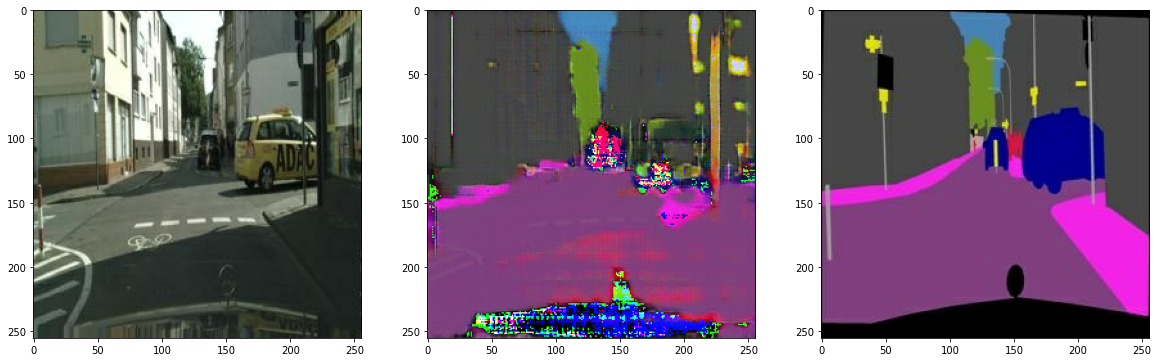

In [62]:
test_ind = 1

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))